In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
%matplotlib inline

In [2]:
t_titre = 35
t_label = 25
fig_width= 15

In [3]:
timeStr = '2017-09-20_151043'
observer = 'LB'
mode = 'enregistrement'
from aSPEM import Analysis
e = Analysis(observer=observer, mode=mode, timeStr=timeStr)

['pari', 'LB', '2017-09-19', '152205']
['enregistrement', 'LB', '2017-09-20', '151043']


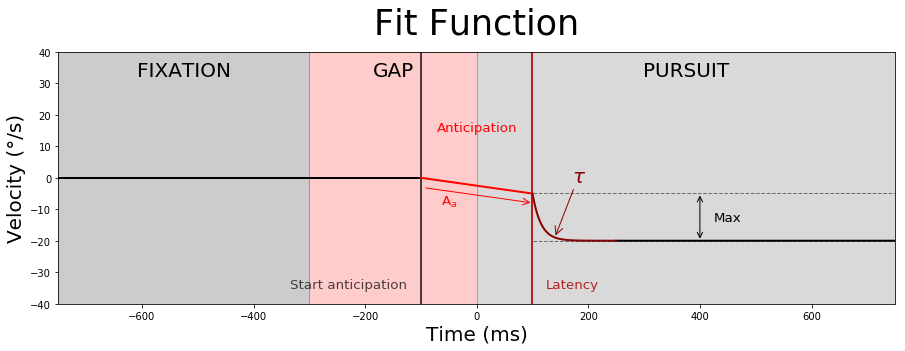

In [4]:
fig, axs= e.plot_fit_fonction()

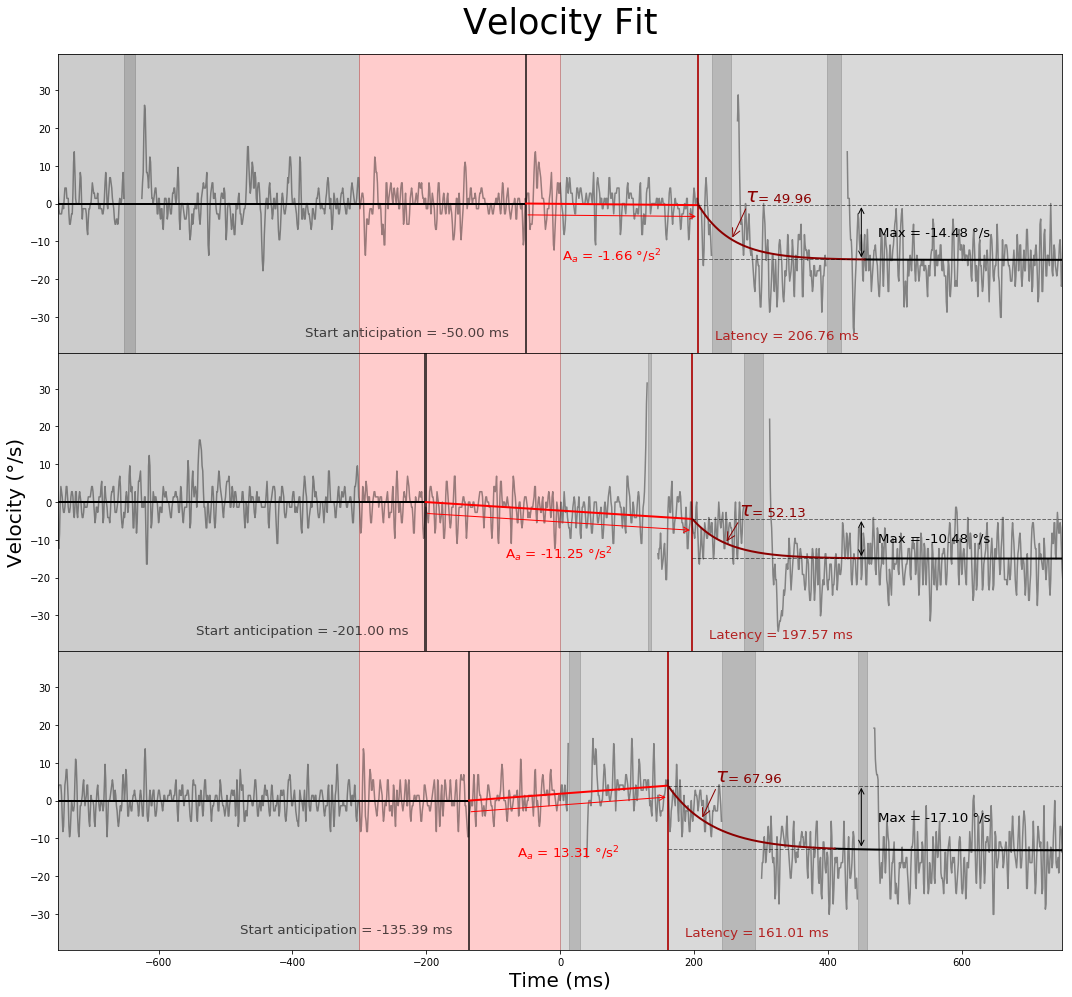

In [5]:
fig, axs= e.plot_velocity_fit()

### Fit

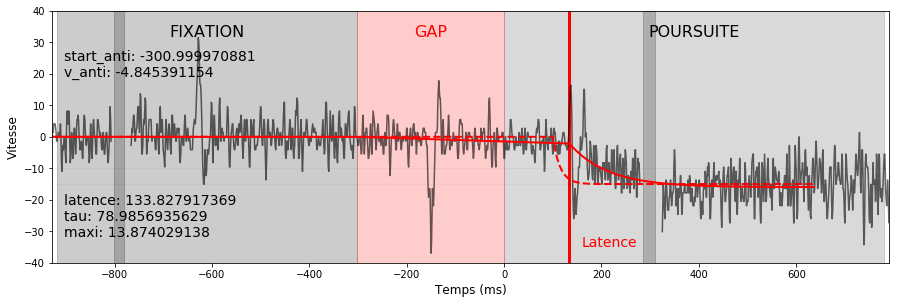

/usr/local/lib/python3.6/site-packages/lmfit/printfuncs.py:140: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))


In [6]:
# pour voir un essai
fig, axs, report = e.Fit_essai()
#print(report)

In [7]:
# pour générer les paramètre fit ainsi que les figures de tout les essais
#e.Fit()